# Overview

This notebook explores the use of UMAP for dimensionality reduction and visualization of gene expression data, with a focus on breast cancer subtypes (PAM50). The workflow includes:

1. **Data Loading & Preprocessing:** Clinical and gene expression datasets are loaded, filtered, and aligned.
2. **UMAP Embedding:** UMAP is applied to both z-scored and log-transformed (collapsed) gene expression matrices to visualize sample clustering by subtype.
3. **Statistical Analysis:** Silhouette scores, ANOVA, and clustering metrics (ARI) are computed to assess separation of subtypes.
4. **Supervised Machine Learning:** Logistic Regression and Random Forest classifiers are trained on UMAP embeddings to predict subtypes, with performance evaluated via cross-validation and test splits.
5. **Integration with Clinical Features:** UMAP embeddings are combined with clinical variables to assess if prediction accuracy improves.
6. **Model Tuning:** Hyperparameter optimization is performed for Random Forest using grid search.

The notebook provides both visual and quantitative assessments of how well gene expression and clinical data can distinguish breast cancer subtypes.

# UMAP
First step is to perform the UMAP, then color it with hue of pam50 subtypes to see how it holds for subtype visualisation

## Imports

In [33]:
import os
from pathlib import Path
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    silhouette_score, accuracy_score, classification_report, confusion_matrix, adjusted_rand_score
)
from sklearn.model_selection import (
    cross_val_score, train_test_split, GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.stats import f_oneway, kruskal

import umap


## Load Data

In [34]:
# Load environment variables and find repo root
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

clinical_path = repo_root / os.getenv("CLINICAL_IMPUTED")
clinical_df_imputed = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


In [35]:
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Collapsed data shape: {collapsed_df.shape}")

Clinical data shape: (3273, 34)
Collapsed data shape: (3273, 26150)


## Z-Scored

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


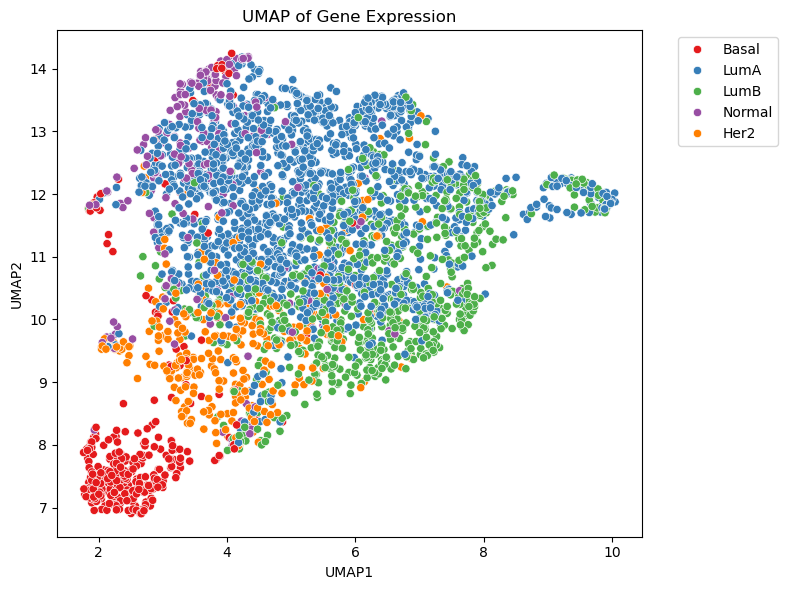

In [36]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(zscored_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=zscored_df.index)
umap_df = umap_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
label_col = 'OG_pam50 subtype'
labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
sil_umap = silhouette_score(umap_result, labels)
print(f"UMAP Silhouette Score (w.r.t {label_col}): {sil_umap:.3f}")


UMAP Silhouette Score (w.r.t OG_pam50 subtype): 0.017


In [38]:
# UMAP1 axis
groups1 = [umap_df['UMAP1'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap1 = f_oneway(*groups1).pvalue
print(f"ANOVA p-value for UMAP1 between {label_col} groups: {anova_umap1:.3e}")

# UMAP2 axis
groups2 = [umap_df['UMAP2'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap2 = f_oneway(*groups2).pvalue
print(f"ANOVA p-value for UMAP2 between {label_col} groups: {anova_umap2:.3e}")


ANOVA p-value for UMAP1 between OG_pam50 subtype groups: 0.000e+00
ANOVA p-value for UMAP2 between OG_pam50 subtype groups: 0.000e+00


In [39]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Logistic Regression accuracy on UMAP embedding: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression accuracy on UMAP embedding: 0.672 ± 0.010


In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(umap_result)
ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Index (ARI) between k-means clusters and {label_col}: {ari:.3f}")


Adjusted Rand Index (ARI) between k-means clusters and OG_pam50 subtype: 0.143


## Collapsed
It is likely that the "collapsed" dataset, which contains the log-transformed but NOT z-scored gene expression matrix could perform better in the UMAP, which is why I check this.

Taking the top 8000 most variable genes -> see variability plot in 03_data_analysis.ipynb, is a trade-off between as much variability captured as possible and reduction of computational complexity for little gain.

In [41]:
N = 8000  
gene_variances = collapsed_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
collapsed_df = collapsed_df[top_genes]


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


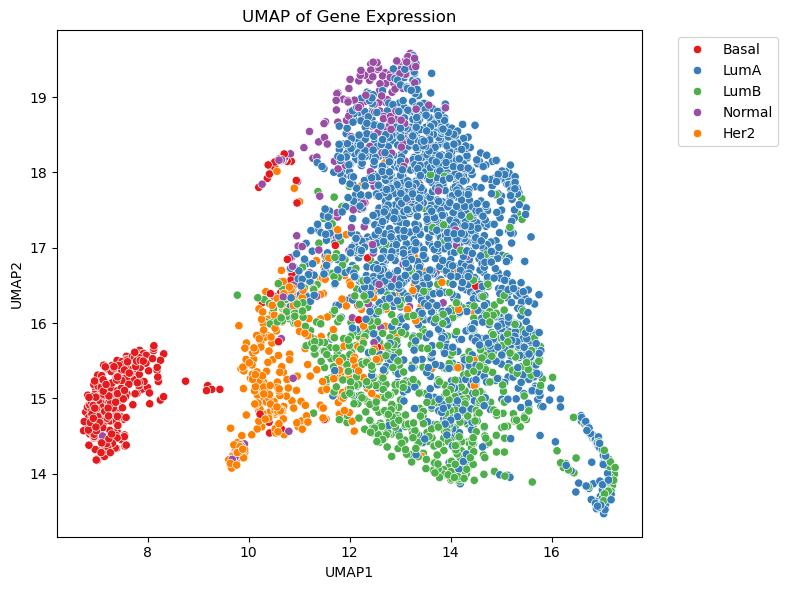

In [42]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As we can see, the Basal subytpe seperates pretty well from the other subtypes, while Luminal A and Luminal B are very similar.

This agrees with cancer biology, since both LumA and LumB are Estrogen-receptor -positive and share similar gene expression patterns -> clustering together makes sense.

In [43]:
sil_umap = silhouette_score(umap_result, labels)
print(f"UMAP Silhouette Score (w.r.t {label_col}): {sil_umap:.3f}")


UMAP Silhouette Score (w.r.t OG_pam50 subtype): 0.082


In [44]:
# UMAP1 axis
groups1 = [umap_df['UMAP1'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap1 = f_oneway(*groups1).pvalue
print(f"ANOVA p-value for UMAP1 between {label_col} groups: {anova_umap1:.3e}")

# UMAP2 axis
groups2 = [umap_df['UMAP2'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap2 = f_oneway(*groups2).pvalue
print(f"ANOVA p-value for UMAP2 between {label_col} groups: {anova_umap2:.3e}")


ANOVA p-value for UMAP1 between OG_pam50 subtype groups: 0.000e+00
ANOVA p-value for UMAP2 between OG_pam50 subtype groups: 0.000e+00


Sginificant differences between groups.

In [45]:
kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(umap_result)
ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Index (ARI) between k-means clusters and {label_col}: {ari:.3f}")


Adjusted Rand Index (ARI) between k-means clusters and OG_pam50 subtype: 0.276


# Supervised ML based on UMAP Embeddings

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_col = 'OG_pam50 subtype'  # Adjust if your column name differs
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(clinical_df[label_col].astype(str))

## Logistic Regression

Starting off with a Logistic regression model -> handles high.dimenstional data well (regularization etc.)

In [47]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Logistic Regression accuracy on UMAP embedding: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression accuracy on UMAP embedding: 0.733 ± 0.008


## Random Forest (5-fold CV)


Random Forest CV accuracy on UMAP embedding: 0.735 ± 0.014

Random Forest test set accuracy on UMAP embedding: 0.750

Classification Report:
               precision  recall  f1-score  support
Basal             0.923   0.882     0.902    68.00
Her2              0.689   0.646     0.667    65.00
LumA              0.777   0.852     0.813   332.00
LumB              0.672   0.616     0.643   146.00
Normal            0.516   0.364     0.427    44.00
accuracy          0.750   0.750     0.750     0.75
macro avg         0.715   0.672     0.690   655.00
weighted avg      0.743   0.750     0.744   655.00


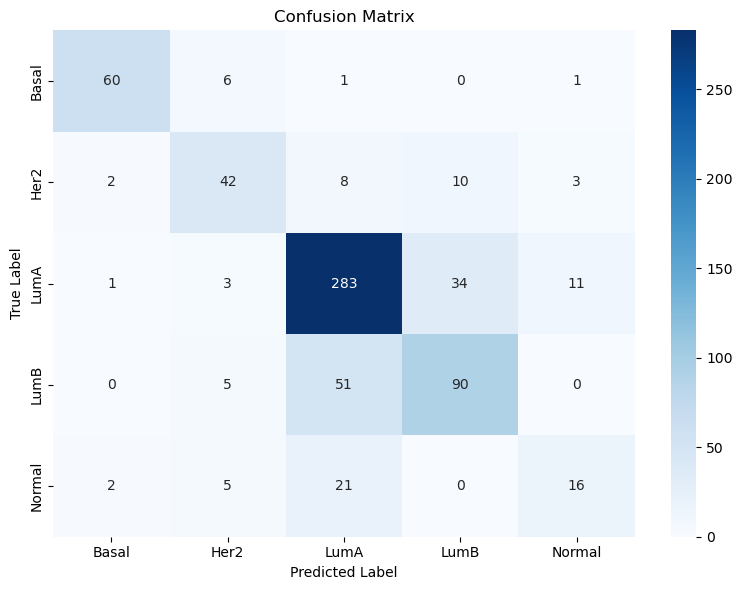

In [48]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"\nRandom Forest CV accuracy on UMAP embedding: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    umap_result, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"\nRandom Forest test set accuracy on UMAP embedding: {test_acc:.3f}\n")

class_names = label_encoder.classes_  # Get the original class names
# ---- Classification Report ----
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:\n", report_df.round(3))

# ---- Confusion Matrix ----

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



### Combined with Full Df

In [49]:
# If the sample names are in the index:
mask = ~clinical_df_imputed.index.str.contains('rep')
clinical_df_imputed = clinical_df_imputed[mask]


In [50]:
clinical_df_imputed.shape

(3273, 35)

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


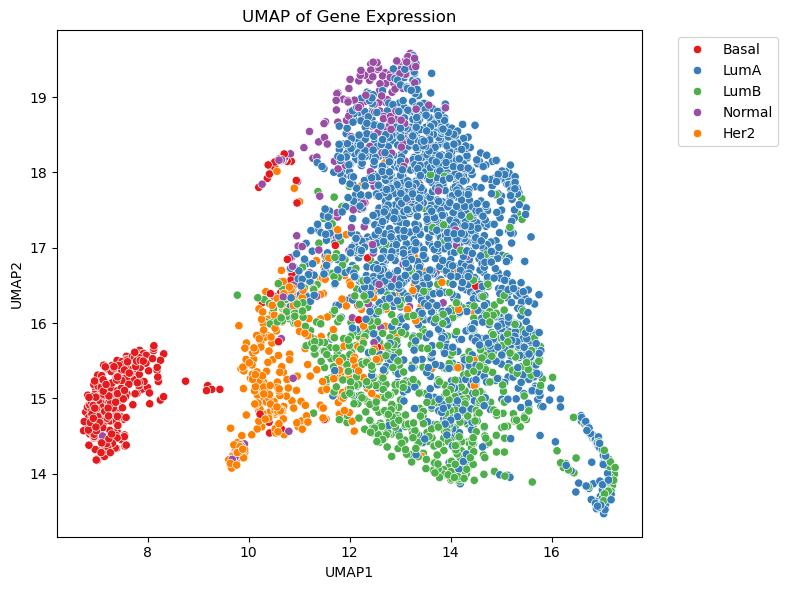

In [51]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df_imputed)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=clinical_df_imputed.index)


cols_to_drop = ['OG_last_update_date', 'OG_instrument model', 
       'er prediction mgc',
       'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc',
       'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc',
       'her2 prediction sgc', 'ki67 prediction sgc', 'OG_pam50 subtype',
       'overall survival days', 'overall survival event', 'endocrine treated',
       'chemo treated', 'OHE_last_update_date__Mar 12 2018',
       'OHE_last_update_date__May 04 2022', 'OHE_instrument model__HiSeq 2000',
       'OHE_instrument model__NextSeq 500', 'OHE_pam50 subtype__Basal',
       'OHE_pam50 subtype__Her2', 'OHE_pam50 subtype__LumA',
       'OHE_pam50 subtype__LumB', 'OHE_pam50 subtype__Normal']

clinical_features = clinical_df_imputed.drop(columns=cols_to_drop, errors='ignore')



# Combine UMAP and clinical features
X_full = pd.concat([umap_df, clinical_features], axis=1)


In [53]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, X_full, labels, cv=5)
print(f"Random Forest CV accuracy (UMAP + clinical): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_full, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Random Forest test set accuracy (UMAP + clinical): {test_acc:.3f}")
print("Classification report on test set:\n", classification_report(y_test, y_pred))


Random Forest CV accuracy (UMAP + clinical): 0.770 ± 0.018
Random Forest test set accuracy (UMAP + clinical): 0.786
Classification report on test set:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89        68
           1       0.77      0.75      0.76        65
           2       0.81      0.86      0.84       332
           3       0.67      0.72      0.69       146
           4       0.89      0.36      0.52        44

    accuracy                           0.79       655
   macro avg       0.81      0.71      0.74       655
weighted avg       0.79      0.79      0.78       655



Performance very similar to the embeddings without the clinical!

In [54]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_full, labels)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.773


# Conclusion

This notebook demonstrates that UMAP is effective for visualizing and separating breast cancer subtypes based on gene expression data, particularly distinguishing the Basal subtype from others. 
- Both z-scored and log-transformed (collapsed) gene expression matrices provide meaningful embeddings, with the collapsed dataset (top 8000 variable genes) showing strong separation. 
- tatistical analyses (silhouette score, ANOVA, ARI) confirm significant differences between subtypes.

Supervised machine learning models (Logistic Regression and Random Forest) trained on UMAP embeddings achieve high accuracy in subtype prediction, and integrating clinical features does not substantially improve performance, suggesting gene expression alone is highly informative for subtype classification. Hyperparameter tuning further optimizes Random Forest accuracy.

Overall, UMAP-based dimensionality reduction combined with machine learning provides robust tools for subtype discovery and prediction in breast cancer transcriptomics.